# 2

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import scipy.linalg as SLA

ModuleNotFoundError: No module named 'cvxpy'

In [23]:
N = 50

def gen_x(n):
    '''return a list of x'''
    return np.array([i/(n-1) for i in range(n)])

def gen_f(x):
    '''return a list of f(x)'''
    ff = []
    for xx in x:
        tmp = 0
        for k in range(4):
            if xx >= (k+1)/5:
                 tmp += 10
        ff.append(tmp) 
    return np.array(ff)

def gen_y(n,f):
    '''return a list of y'''
    yy = np.zeros(n)
    for i in range(n):
        if i == 24:
            yy[i] = 0
        else:
            yy[i] = f[i] + np.random.randn()
    return yy

def kernel_rbf(x, z, gamma):
    '''return the kernel matrix between x and z''' 
    return np.exp(-gamma*(x-z)*(x-z))

def ls_obj_fn(alpha, k, y, lamb):
    '''return least square objective function'''
    return cp.pnorm(k@alpha - y, p=2)**2 + \
            lamb*cp.pnorm(np.real(SLA.sqrtm(k))@alpha, p=2)**2

def huber_obj_fn(alpha, k, y, lamb):
    '''return huber objective function'''
    return cp.sum(cp.huber(k@alpha - y)) + \
            lamb*cp.pnorm(np.real(SLA.sqrtm(k))@alpha, p=2)**2

def D(n):
    '''return D matrix'''
    tv = 0
    mat = np.zeros((n-1, n))
    for i in range(n-1):
        mat[i,i] = -1
        mat[i,i+1] = 1
    return mat

def tv_obj_fn(alpha, k, y, lamb1, lamb2):
    '''return the objective function including a TV term'''
    return cp.pnorm(k@alpha - y, p=2)**2 + \
            lamb1*cp.pnorm(D(len(k))@k@alpha, p=1) + \
            lamb2*cp.pnorm(np.real(SLA.sqrtm(k))@alpha, p=2)**2

def cvx_optmz(x, y, k, loss_fn, lamb=None, lamb1=None, lamb2=None):
    '''do cvxpy optimization and return obtained alpha'''
    alpha = cp.Variable(len(x))
    if loss_fn == 'ls' or loss_fn == 'constr':
        objective = cp.Minimize(ls_obj_fn(alpha, k, y, lamb))
    elif loss_fn == 'huber':
        objective = cp.Minimize(huber_obj_fn(alpha, k, y, lamb))
    elif loss_fn == 'tv':
        objective = cp.Minimize(tv_obj_fn(alpha, k, y, lamb1, lamb2))
    if loss_fn != 'constr':
        prob = cp.Problem(objective)
    else:
        constrains = [D(len(k))@k@alpha >= 0]
        prob = cp.Problem(objective, constrains)
    prob.solve()
    return alpha.value

def bootstrap(X, Y, loss_fn):
    '''return best lambda and gamma'''
    
    obj_list = []
    lamb_list = []
    gamma_list = []
    for gamma in [50, 100, 200, 300]:
        lamb = 1.0
        while lamb > 1e-4:
            obj = 0
            for i in range(N):  
                # extract training data and validation data
                X_tr = np.append(X[0:i], X[i+1:N])
                Y_tr = np.append(Y[0:i], Y[i+1:N])
                X_va = X[i]
                Y_va = Y[i]
                # calculate kernel matrix for training and CV
                K = kernel_rbf(X_tr[:,np.newaxis],X_tr[np.newaxis,:], gamma)
                K_va = np.exp(-gamma*np.square(X_va-X_tr[np.newaxis,:]))
                # get alpha from cvx optimization
                alpha = cvx_optmz(X_tr, Y_tr, K, loss_fn, lamb)
                # calculate the loss
                if loss_fn == 'ls' or loss_fn == 'constr':
                    obj += (cp.pnorm(K_va@alpha - Y_va, p=2)**2).value
                elif loss_fn == 'huber':
                    obj += (cp.sum(cp.huber(K_va@alpha - Y_va))).value
            # store the results for each lambda in one list
            obj_list.append(obj)
            lamb_list.append(lamb) 
            gamma_list.append(gamma)
            lamb /= 2 
    # pick the lamb that makes the total loss least
    lamb_best = lamb_list[obj_list.index(np.min(obj_list))]
    gamma_best = gamma_list[obj_list.index(np.min(obj_list))] 
    return lamb_best, gamma_best

def bootstrap_tv(X, Y, loss_fn):
    '''return the best lamb1, lamb2 and gamma'''
    
    obj_list = []
    lamb1_list = []
    lamb2_list = []
    gamma_list = []
    for gamma in [200]:
        lamb1 = 6.0
        while lamb1 > 1:
            lamb2 = 1.0
            while lamb2 > 1e-2:
                obj = 0
                for i in range(N):  
                    # extract training data and validation data
                    X_tr = np.append(X[0:i], X[i+1:N])
                    Y_tr = np.append(Y[0:i], Y[i+1:N])
                    X_va = X[i]
                    Y_va = Y[i]
                    # calculate kernel matrix for training and CV
                    K = kernel_rbf(X_tr[:,np.newaxis],X_tr[np.newaxis,:], gamma)
                    K_va = np.exp(-gamma*(X_va-X_tr[np.newaxis,:])**2)
                    # get alpha from cvx optimization
                    alpha = cvx_optmz(X_tr, Y_tr, K, loss_fn, lamb1=lamb1, lamb2=lamb2)
                    # calculate the loss
                    if loss_fn == 'tv':
                        obj += (cp.pnorm(K_va@alpha - Y_va, p=2)**2).value

            # store the results for each lambda in one list
                obj_list.append(obj)
                lamb1_list.append(lamb1) 
                lamb2_list.append(lamb2)
                gamma_list.append(gamma)
                lamb2 /= 2 
            lamb1 /= 1.2
    # pick the lamb that makes the total loss least
    lamb1_best = lamb1_list[obj_list.index(np.min(obj_list))]
    lamb2_best = lamb2_list[obj_list.index(np.min(obj_list))]
    gamma_best = gamma_list[obj_list.index(np.min(obj_list))]
    return lamb1_best, lamb2_best, gamma_best

def fn_rbf(X, Y, loss_fn):
    '''return rbf f(x)'''
    #gamma = cal_gamma(X[:,np.newaxis], X[np.newaxis,:])
    
    f_list = []
    if loss_fn != 'tv':
        lamb, gamma = bootstrap(X,Y,loss_fn)
        print(gamma)
        k = kernel_rbf(X[:,np.newaxis],X[np.newaxis,:], gamma)
        alpha = np.array(cvx_optmz(X, Y, k, loss_fn, lamb)).reshape((1,N))
    else:
        lamb1, lamb2, gamma = bootstrap_tv(X,Y,loss_fn)
        k = kernel_rbf(X[:,np.newaxis],X[np.newaxis,:], gamma)
        alpha = np.array(cvx_optmz(X, Y, k, loss_fn, lamb1=lamb1, lamb2=lamb2)).reshape((1,N))
        
    for x in X:
        f_list.append(np.sum(alpha * kernel_rbf(x, X, gamma)))
    return np.array(f_list)

def plot_2(x, y, f, ff):
    '''plot of problem 2.a'''
    plt.figure()
    plt.plot(x, y, 'ro', label = 'original data')
    plt.plot(x, f, 'b-', label = 'true f(x)')
    plt.plot(x, ff, 'g-', label = 'rbf f(x)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

In [8]:
X = gen_x(N)
F = gen_f(X)
Y = gen_y(N,F)

## 2.a

50


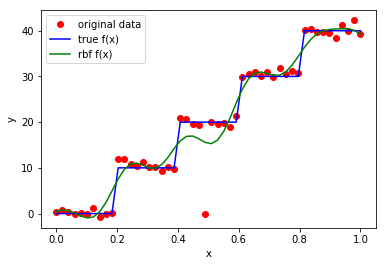

In [24]:
Fls = fn_rbf(X, Y, 'ls')     
plot_2(X,Y,F,Fls)

## 2.b

200


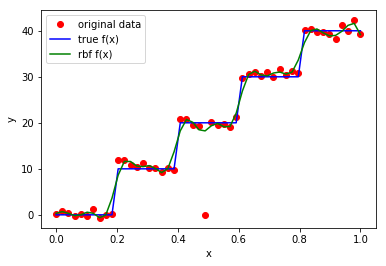

In [10]:
Fhuber = fn_rbf(X, Y, 'huber') 
plot_2(X,Y,F,Fhuber)

## 2.c

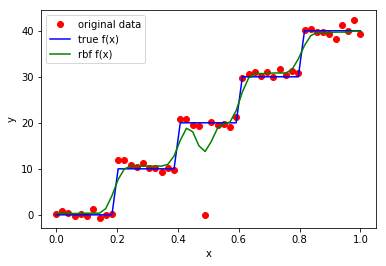

In [21]:
Ftv = fn_rbf(X, Y, 'tv') 
plot_2(X,Y,F,Ftv)

## 2.d

200


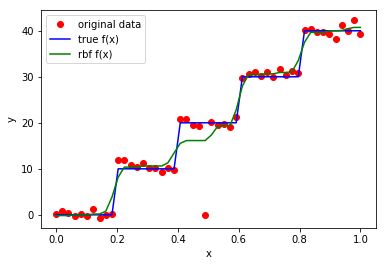

In [22]:
Fconstr = fn_rbf(X, Y, 'constr') 
plot_2(X,Y,F,Fconstr)

# 3

In [54]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [5]:
# transform the datasets to Tensors of normalized range [-1,1]

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 10)
    
    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = self.fc1(x)
        return x

In [7]:
class Net2(nn.Module):
    def __init__(self, M):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(32*32*3, M)
        self.fc2 = nn.Linear(M, 10)
    
    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [79]:
class Net3(nn.Module):
    def __init__(self, M, p, N):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(3, M, p)
        self.pool = nn.MaxPool2d(N,N)
        self.fc1 = nn.Linear(M*(int((33-p)/N))**2, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        return x
        
    def num_flat_features(self, x):
        size = x.size()[1:] # except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [9]:
class Net4(nn.Module):
    def __init__(self, M1, M2, M3, p):
        super(Net4, self).__init__()
        self.conv1 = nn.Conv2d(3,M1,p)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(M1,M2,p)
        self.fc1 = nn.Linear(M2*p*p, 120)
        self.fc2 = nn.Linear(120, M3)
        self.fc3 = nn.Linear(M3, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [27]:
def train_and_test(net, lr, momentum):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr, momentum)
    accuracy_trs = []
    accuracy_tes = []
    for epoch in range(12): # loop over the dataset multiple times
        running_loss = 0.0
        total_tr = 0
        correct_tr = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # compute training corrections
            running_loss += loss.item()
            _,predicted = torch.max(outputs.data, 1)
            total_tr += labels.size(0)
            correct_tr += (predicted == labels).sum().item()

        # compute test corrections    
        correct_te = 0
        total_te = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                outputs = net(images)
                _,predicted = torch.max(outputs.data, 1)
                total_te += labels.size(0)
                correct_te += (predicted == labels).sum().item()
                
        accuracy_trs.append(correct_tr / total_tr)
        accuracy_tes.append(correct_te / total_te)
        #if best == True:
        #    print('epoch %d -- training accuracy is : %d %%; testing accuracy is: %d %%' %\
        #      (epoch+1, 100*accuracy_trs[-1], 100*accuracy_tes[-1]))
    return accuracy_trs, accuracy_tes

In [91]:
def gen_index_a(x1, x2):
    inds = []
    for ii in range(len(x1)):
        for jj in range(len(x2)):
            inds.append((ii, jj))
    np.random.shuffle(inds)
    return inds

In [62]:
def gen_index_b(x1, x2, x3):
    inds = []
    for ii in range(len(x1)):
        for jj in range(len(x2)):
            for kk in range(len(x3)):
                inds.append((ii, jj, kk))
    np.random.shuffle(inds)
    return inds

In [69]:
def gen_index_c(x1, x2, x3, x4, x5):
    inds = []
    for ii in range(len(x1)):
        for jj in range(len(x2)):
            for kk in range(len(x3)):
                for mm in range(len(x4)):
                    for nn in range(len(x5)):
                        inds.append((ii, jj, kk, mm, nn))
    np.random.shuffle(inds)
    return inds

In [52]:
def plot_3(accu_trs, accu_tes):
    '''plots for problem 3'''
    x_axis = [j+1 for j in range(len(accu_trs))]
    plt.figure()
    plt.plot(x_axis, accu_trs, 'bo-', label = 'training accuracy')
    plt.plot(x_axis, accu_tes, 'ro-', label = 'test accuracy')
    plt.xlabel('iteration steps')
    plt.ylabel('classification accuracies')
    plt.legend()
    plt.show()

## 3.a

In [92]:
last_accu = []
momentum_list = [0.2, 0.5, 0.9, 1.5, 2, 4]
lr_list = [1e-5, 1e-4, 1e-3, 1e-2]
all_tr = []
all_te = []
momentums = []
lrs = []
inds = gen_index_a(momentum_list, lr_list)

for (i,j) in inds[0:8]:
    
    momentum = momentum_list[i]
    lr = lr_list[j]
    momentums.append(momentum)
    lrs.append(lr)
    
    net1 = Net1()
    accu_trs, accu_tes = train_and_test(net1, lr, momentum)

    all_tr.append(accu_trs)
    all_te.append(accu_tes)

    accu_te = accu_tes[-1]
    last_accu.append(accu_te)
    print('momentum: %f; lr: %f; accuracy: %f' % (momentum, lr, accu_te))

momentum: 1.500000; lr: 0.000100; accuracy: 0.100000
momentum: 0.500000; lr: 0.000100; accuracy: 0.409200
momentum: 0.500000; lr: 0.000010; accuracy: 0.382300
momentum: 0.500000; lr: 0.001000; accuracy: 0.389800
momentum: 0.900000; lr: 0.000010; accuracy: 0.407500
momentum: 0.900000; lr: 0.001000; accuracy: 0.333800
momentum: 2.000000; lr: 0.001000; accuracy: 0.100000
momentum: 4.000000; lr: 0.000100; accuracy: 0.100000


In [93]:
best_index = last_accu.index(np.max(last_accu))

momentum_best = momentums[best_index]
lr_best = lrs[best_index]
accu_trs = all_tr[best_index]
accu_tes = all_te[best_index]

In [94]:
print('Hyper-parameters -- momentum: %f; lr: %f' % \
      (momentum_best, lr_best))

Hyper-parameters -- momentum: 0.500000; lr: 0.000100


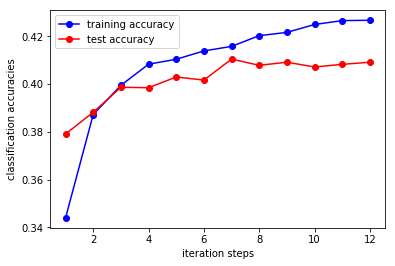

In [95]:
plot_3(accu_trs, accu_tes)

## 3.b

In [63]:
last_accu = []
M_list = [50, 100, 200, 500, 1000]
momentum_list = [0.2, 0.5, 0.9, 1.5]
lr_list = [1e-5, 1e-4, 1e-3, 1e-2]
all_tr = []
all_te = []
momentums = []
lrs = []
Ms = []
inds = gen_index_b(momentum_list, lr_list, M_list)

for (i, j, k) in inds[0:8]:
    
    momentum = momentum_list[i]
    lr = lr_list[j]
    M = M_list[k]
    momentums.append(momentum)
    lrs.append(lr)
    Ms.append(M)
    
    net2 = Net2(M)
    accu_trs, accu_tes = train_and_test(net2, lr, momentum)
    
    all_tr.append(accu_trs)
    all_te.append(accu_tes)
    
    accu_te = accu_tes[-1]
    last_accu.append(accu_te)
    print('M: %d; momentum: %f; lr: %f; accuracy: %f' % (M, momentum, lr, accu_te))

best_index = last_accu.index(np.max(last_accu))

momentum_best = momentums[best_index]
lr_best = lrs[best_index]
M_best = Ms[best_index]
accu_trs = all_tr[best_index]
accu_tes = all_te[best_index]

M: 100; momentum: 1.500000; lr: 0.001000; accuracy: 0.100000
M: 100; momentum: 0.500000; lr: 0.010000; accuracy: 0.470800
M: 500; momentum: 0.500000; lr: 0.001000; accuracy: 0.533300
M: 50; momentum: 1.500000; lr: 0.000010; accuracy: 0.100000
M: 100; momentum: 0.900000; lr: 0.010000; accuracy: 0.100000
M: 500; momentum: 1.500000; lr: 0.000010; accuracy: 0.100000
M: 500; momentum: 0.200000; lr: 0.000100; accuracy: 0.460300
M: 500; momentum: 0.500000; lr: 0.000100; accuracy: 0.477700


In [65]:
print('Hyper-parameters -- M: %d; momentum: %f; lr: %f' % \
      (M_best, momentum_best, lr_best))

Hyper-parameters -- M: 500; momentum: 0.500000; lr: 0.001000


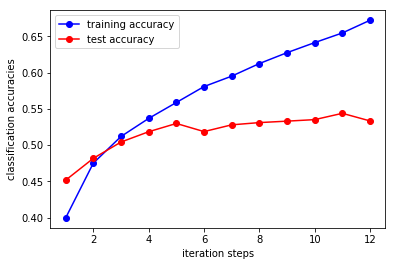

In [64]:
plot_3(accu_trs, accu_tes)

## 3.c

In [86]:
last_accu = []
momentum_list = [0.2, 0.5, 0.9, 1.2]
lr_list = [1e-5, 1e-4, 1e-3, 1e-2]
M_list = [50, 100, 200, 500]
p_list = [2, 3, 5, 10]
N_list = [4, 14, 18]

all_tr = []
all_te = []

momentums = []
lrs = []
Ms = []
ps = []
Ns = []
inds = gen_index_c(momentum_list, lr_list, M_list, p_list, N_list)

for (j1, j2, j3, j4, j5) in inds[0:12]:
    
    momentum = momentum_list[j1]
    lr = lr_list[j2]
    M = M_list[j3]
    p = p_list[j4]
    N = N_list[j5]
    
    momentums.append(momentum)
    lrs.append(lr)
    Ms.append(M)
    ps.append(p)
    Ns.append(N)
    
    net3 = Net3(M, p, N)
    accu_trs, accu_tes = train_and_test(net3, lr, momentum)
    
    all_tr.append(accu_trs)
    all_te.append(accu_tes)
    
    accu_te = accu_tes[-1]
    last_accu.append(accu_te)
    print('momentum: %f; lr: %f; M: %d; p: %d; N: %d; accuracy: %.3f' % (momentum, lr, M, p, N, accu_te))

best_index = last_accu.index(np.max(last_accu))

momentum_best = momentums[best_index]
lr_best = lrs[best_index]
M_best = Ms[best_index]
p_best = ps[best_index]
N_best = Ns[best_index]

accu_trs = all_tr[best_index]
accu_tes = all_te[best_index]

momentum: 1.200000; lr: 0.000010; M: 500; p: 3; N: 14; accuracy: 0.100
momentum: 0.900000; lr: 0.001000; M: 500; p: 10; N: 4; accuracy: 0.633
momentum: 0.200000; lr: 0.010000; M: 50; p: 5; N: 18; accuracy: 0.490
momentum: 0.500000; lr: 0.000010; M: 50; p: 2; N: 14; accuracy: 0.258
momentum: 0.500000; lr: 0.010000; M: 500; p: 2; N: 18; accuracy: 0.413
momentum: 1.200000; lr: 0.000010; M: 200; p: 10; N: 4; accuracy: 0.100
momentum: 0.900000; lr: 0.000010; M: 50; p: 10; N: 14; accuracy: 0.340
momentum: 1.200000; lr: 0.000100; M: 50; p: 5; N: 18; accuracy: 0.100
momentum: 0.200000; lr: 0.000100; M: 500; p: 3; N: 18; accuracy: 0.308
momentum: 0.900000; lr: 0.000100; M: 200; p: 2; N: 14; accuracy: 0.485
momentum: 1.200000; lr: 0.010000; M: 200; p: 5; N: 14; accuracy: 0.100
momentum: 0.500000; lr: 0.000010; M: 50; p: 2; N: 18; accuracy: 0.140


In [89]:
print('Hyper-parameters -- M: %d; momentum: %f; lr: %f; p: %d; N: %d' % \
      (M_best, momentum_best, lr_best, p_best, N_best))

Hyper-parameters -- M: 500; momentum: 0.900000; lr: 0.001000; p: 10; N: 4


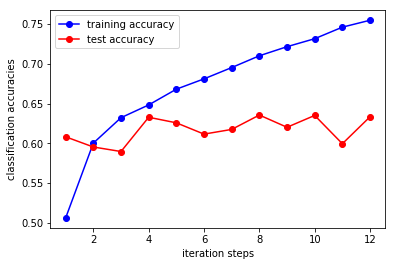

In [87]:
plot_3(accu_trs, accu_tes)

## 3.d

In [ ]:
net4 = Net4(6,16,84,5)
train_and_test(net2, 0.001, 0.9)